In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, log_loss
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import plotly.graph_objs as go
from lightweight_charts import Panel, chart, PlotDFAccessor, PlotSRAccessor

class RollingWindowTrainer:
    def __init__(self, train_days=5, test_days=1):
        self.train_days = train_days
        self.test_days = test_days
        self.window_size = train_days + test_days
        self.results = []
        
    def get_day_groups(self, df):
        """Group data by days using datetime index"""
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
        return df.groupby(df.index.date)
        
    def plot_confusion_matrix(self, cm, title, ax=None):
        """Plot confusion matrix using seaborn"""
        if ax is None:
            _, ax = plt.subplots(figsize=(6, 5))
            
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Down', 'Neutral', 'Up'],
                   yticklabels=['Down', 'Neutral', 'Up'])
        ax.set_title(title)
        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')
    
    def calculate_confusion_metrics(self, cm):
        """Calculate metrics from directional confusion matrix for multi-class classification"""
        total = np.sum(cm)
        
        # Calculate accuracy
        accuracy = np.sum(np.diag(cm)) / total
        
        # Calculate per-class metrics
        n_classes = cm.shape[0]
        metrics = {
            'Accuracy': accuracy,
            'Total Samples': total,
            'Class Metrics': {}
        }
        
        for i in range(n_classes):
            # True positives for class i
            tp = cm[i, i]
            # False positives for class i
            fp = np.sum(cm[:, i]) - tp
            # False negatives for class i
            fn = np.sum(cm[i, :]) - tp
            
            # Calculate metrics for class i
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            class_name = ['Down', 'Neutral', 'Up'][i]
            metrics['Class Metrics'][class_name] = {
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1
            }
        
        return metrics
    
    def run_rolling_window(self, df, n_iterations=None, n_trials=50):
        """
        Run rolling window analysis for specified number of iterations with classification
        
        Classes:
        0 - Down (target < -threshold)
        1 - Neutral (-threshold <= target <= threshold)
        2 - Up (target > threshold)
        where threshold = 0.2 * std(train_data['target'])
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe with datetime index
        n_iterations : int or None
            Number of iterations to run. If None, runs through entire dataset.
            If specified, validates against maximum possible iterations.
        n_trials : int
            Number of trials for hyperparameter optimization
            
        Returns:
        --------
        pandas.DataFrame
            Results dataframe with predictions and metadata
        """
        self.results = []
        
        # Group data by days
        day_groups = self.get_day_groups(df)
        unique_days = list(day_groups.groups.keys())
        
        # Calculate maximum possible iterations
        max_iterations = len(unique_days) - self.train_days
        
        if max_iterations <= 0:
            raise ValueError(f"Dataset contains {len(unique_days)} days, but {self.train_days} training days are required. Need at least {self.train_days + 1} days.")
        
        # Validate/set n_iterations
        if n_iterations is None:
            n_iterations = max_iterations
        else:
            n_iterations = min(n_iterations, max_iterations)
            
        print(f"Running {n_iterations} iterations out of maximum possible {max_iterations} iterations")
        
        for i in range(n_iterations):
            print(f"\nIteration {i+1}/{n_iterations}")
            
            # Get indices for train and test days
            train_start_idx = i
            train_end_idx = train_start_idx + self.train_days
            test_idx = train_end_idx
            
            if test_idx >= len(unique_days):
                print("Reached end of data")
                break
                
            # Get train and test data
            train_days = unique_days[train_start_idx:train_end_idx]
            test_day = unique_days[test_idx]
            
            train_data = pd.concat([day_groups.get_group(day) for day in train_days])
            test_data = day_groups.get_group(test_day)
            
            print(f"Training days: {train_days[0]} to {train_days[-1]}")
            print(f"Test day: {test_day}")
            
            #STD DEV THRESHOLD
            # # Calculate threshold based on training data
            # threshold = 0.5 * train_data['target'].std()
            # print(f"Classification threshold: ±{threshold:.6f}")
            
            # # Transform targets to classes
            # def transform_to_classes(x, threshold):
            #     if x < -threshold:
            #         return 0  # Down
            #     elif x > threshold:
            #         return 2  # Up
            #     else:
            #         return 1  # Neutral
            
            # # Transform train and test targets
            # train_targets = train_data['target'].apply(lambda x: transform_to_classes(x, threshold))
            # test_targets = test_data['target'].apply(lambda x: transform_to_classes(x, threshold))
            
            #PERCENTILE BASED
            # Calculate threshold top/bottom 10% 
            percentile_threshold = 0.1
            top_threshold = train_data['target'].quantile(1 - percentile_threshold)
            bottom_threshold = train_data['target'].quantile(percentile_threshold)
            
            def transform_to_classes(x, top_threshold, bottom_threshold):
                if x < bottom_threshold:
                    return 0  # Down
                elif x > top_threshold:
                    return 2  # Up
                else:
                    return 1  # Neutral

            train_targets = train_data['target'].apply(lambda x: transform_to_classes(x, top_threshold, bottom_threshold))
            test_targets = test_data['target'].apply(lambda x: transform_to_classes(x, top_threshold, bottom_threshold))

            plt.subplot(2, 2, 4)
            sns.histplot(data=pd.DataFrame({'return': train_data['target'], 'class': train_targets}), 
                        x='return', hue='class', bins=100)
            plt.title(f'Train - Classes Based on {percentile_threshold*100}th Percentiles')
            plt.axvline(x=top_threshold, color='g', linestyle='--', alpha=0.5)
            plt.axvline(x=bottom_threshold, color='r', linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

            plt.subplot(2, 2, 4)
            sns.histplot(data=pd.DataFrame({'return': test_data['target'], 'class': test_targets}), 
                        x='return', hue='class', bins=100)
            plt.title(f'Test - Classes Based on {percentile_threshold*100}th Percentiles')
            plt.axvline(x=top_threshold, color='g', linestyle='--', alpha=0.5)
            plt.axvline(x=bottom_threshold, color='r', linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

            # Print class distribution in training data
            train_class_dist = train_targets.value_counts().sort_index()
            print("\nTraining class distribution:")
            print(f"Down (0): {train_class_dist.get(0, 0)}")
            print(f"Neutral (1): {train_class_dist.get(1, 0)}")
            print(f"Up (2): {train_class_dist.get(2, 0)}")
            
            X_test_temp = test_data.copy()

            # Prepare features
            X_train = train_data.drop('target', axis=1)
            X_test = test_data.drop('target', axis=1)
            
            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Define parameter space for optimization
            def objective(trial):
                params = {
                    'max_depth': trial.suggest_int('max_depth', 3, 8),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
                    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                    'gamma': trial.suggest_float('gamma', 0, 0.5)
                }
                
                model = xgb.XGBClassifier(
                    objective='multi:softprob',
                    num_class=3,
                    use_label_encoder=False,
                    eval_metric='mlogloss',
                    **params
                )
                
                model.fit(
                    X_train_scaled,
                    train_targets,
                    verbose=False
                )
                
                # Predict probabilities
                pred_proba = model.predict_proba(X_train_scaled)
                # Calculate log loss
                return log_loss(train_targets, pred_proba, labels=[0, 1, 2])
            
            # Optimize hyperparameters
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial), n_trials=n_trials)
            
            # Train final model with best parameters
            best_model = xgb.XGBClassifier(
                objective='multi:softprob',
                num_class=3,
                use_label_encoder=False,
                eval_metric='mlogloss',
                **study.best_params
            )
            best_model.fit(X_train_scaled, train_targets)
            
            # Make predictions
            pred_proba = best_model.predict_proba(X_test_scaled)
            predictions = best_model.predict(X_test_scaled)
            
            X_test_temp["predictions"] = predictions
            X_test_temp["target_classed"] = test_targets

            Panel(
                # auto_scale=[cdlbreakaway],
                # ohlcv=(t1data.ohlcv.data["BAC"],entries),
                histogram=[],
                right=[(X_test_temp["close"], "close") if "close" in X_test_temp.columns else ()],
                left=[],
                middle1=[(X_test_temp["predictions"],"predicictions"),(X_test_temp["target_classed"],"target_classed")],
                middle2=[(X_test_temp["target"], "target")]
                ).chart(size="s", precision=4)

            # Plot predictions vs actual
            fig = go.Figure()

            # Add first y-axis (left) with predictions and target_classed
            fig.add_trace(go.Scatter(x=X_test_temp.index, y=X_test_temp["predictions"],
                                    mode='lines', name='Predictions', line=dict(color='blue')))
            fig.add_trace(go.Scatter(x=X_test_temp.index, y=X_test_temp["target_classed"],
                                    mode='lines', name='Target Classed', line=dict(color='orange')))

            # Add second y-axis (right) with target
            fig.add_trace(go.Scatter(x=X_test_temp.index, y=X_test_temp["target"],
                                    mode='lines', name='Target', line=dict(color='green'), yaxis="y2"))

            #if there is close in data, display it
            if "close" in X_test_temp.columns:
                fig.add_trace(go.Scatter(x=X_test_temp.index, y=X_test_temp["close"],
                                        mode='lines', name='Close', line=dict(color='gray'), yaxis="y3"))

            # Set up layout with dual y-axes
            fig.update_layout(
                title="Predictions, Target Classed, and Target",
                xaxis=dict(title="Date"),
                yaxis=dict(title="Predictions and Target Classed", side="left"),
                yaxis2=dict(title="Target", overlaying="y", side="right"),
                yaxis3=dict(title="Close", overlaying="y"),
                legend=dict(x=0.01, y=0.99)
            )

            # Display the figure
            fig.show()


            # Store results
            for idx, (timestamp, true, pred, probs) in enumerate(zip(
                test_data.index, test_targets, predictions, pred_proba)):
                self.results.append({
                    'iteration': i + 1,
                    'timestamp': timestamp,
                    'date': timestamp.date(),
                    'time': timestamp.time(),
                    'actual': true,
                    'predicted': pred,
                    'prob_down': probs[0],
                    'prob_neutral': probs[1],
                    'prob_up': probs[2],
                    'train_start': train_days[0],
                    'train_end': train_days[-1],
                    'top_threshold': top_threshold,
                    'bottom_threshold': bottom_threshold,
                    'validation_score': study.best_value,
                    'raw_target': test_data.iloc[idx]['target']  # store original target value
                })
        
        # Convert results to DataFrame
        self.results_df = pd.DataFrame(self.results)
        
        # Print overall class distribution
        print("\nOverall results class distribution:")
        print("Actual:")
        print(self.results_df['actual'].value_counts().sort_index())
        print("\nPredicted:")
        print(self.results_df['predicted'].value_counts().sort_index())
        
        return self.results_df
    
    def evaluate_and_plot(self):
        """Evaluate results and create comprehensive plots with probability analysis"""
        if not hasattr(self, 'results_df'):
            print("No results to evaluate. Run rolling_window analysis first.")
            return
            
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 20))
        gs = fig.add_gridspec(4, 2)
        
        # Plot 1: Actual vs Predicted over time
        ax1 = fig.add_subplot(gs[0, :])
        ax1.plot(self.results_df['timestamp'], self.results_df['actual'], 
                label='Actual', marker='o')
        ax1.plot(self.results_df['timestamp'], self.results_df['predicted'], 
                label='Predicted', marker='o')
        
        for date in self.results_df['date'].unique():
            ax1.axvline(x=pd.Timestamp(date), color='gray', linestyle='--', alpha=0.5)
            
        ax1.set_title('Actual vs Predicted Values Over Time')
        ax1.legend()
        
        # Plot 2: Prediction Probabilities
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.plot(self.results_df['timestamp'], self.results_df['prob_down'], 
                label='Down Prob', alpha=0.7)
        ax2.plot(self.results_df['timestamp'], self.results_df['prob_neutral'], 
                label='Neutral Prob', alpha=0.7)
        ax2.plot(self.results_df['timestamp'], self.results_df['prob_up'], 
                label='Up Prob', alpha=0.7)
        ax2.set_title('Prediction Probabilities Over Time')
        ax2.legend()
        
        # Plot 3: Overall Confusion Matrix
        ax3 = fig.add_subplot(gs[1, 1])
        overall_cm = confusion_matrix(self.results_df['actual'], 
                                    self.results_df['predicted'],
                                    labels=[0, 1, 2])
        self.plot_confusion_matrix(overall_cm, 'Overall Confusion Matrix', ax3)
        
        # NEW: Plot 4: Probability Distribution vs Raw Target
        ax4 = fig.add_subplot(gs[2, 0])
        scatter = ax4.scatter(self.results_df['raw_target'], 
                            self.results_df['prob_up'],
                            c=self.results_df['predicted'],
                            cmap='viridis',
                            alpha=0.6)
        ax4.set_xlabel('Actual Return')
        ax4.set_ylabel('Probability of Up Movement')
        ax4.set_title('Up Probability vs Actual Return')
        ax4.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
        ax4.axvline(x=0, color='r', linestyle='--', alpha=0.3)
        plt.colorbar(scatter, label='Predicted Class')
        
        # NEW: Plot 5: Probability Threshold Analysis
        ax5 = fig.add_subplot(gs[2, 1])
        thresholds = np.linspace(0.3, 0.7, 20)
        accuracies = []
        precisions = []
        recalls = []
        
        for thresh in thresholds:
            # Create binary predictions based on probability threshold
            binary_pred = (self.results_df['prob_up'] > thresh).astype(int)
            binary_actual = (self.results_df['raw_target'] > 0).astype(int)
            
            accuracies.append(accuracy_score(binary_actual, binary_pred))
            precisions.append(precision_score(binary_actual, binary_pred))
            recalls.append(recall_score(binary_actual, binary_pred))
        
        ax5.plot(thresholds, accuracies, label='Accuracy', marker='o')
        ax5.plot(thresholds, precisions, label='Precision', marker='o')
        ax5.plot(thresholds, recalls, label='Recall', marker='o')
        ax5.set_xlabel('Probability Threshold')
        ax5.set_ylabel('Score')
        ax5.set_title('Metric Scores vs Probability Threshold')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # NEW: Plot 6: Return Distribution by Prediction Confidence
        ax6 = fig.add_subplot(gs[3, 0])
        # Get maximum probability for each prediction
        self.results_df['max_prob'] = self.results_df[['prob_down', 'prob_neutral', 'prob_up']].max(axis=1)
        confidence_bins = np.linspace(0.33, 1, 4)  # Create 3 confidence bins
        self.results_df['confidence_level'] = pd.cut(self.results_df['max_prob'], 
                                                bins=confidence_bins,
                                                labels=['Low', 'Medium', 'High'])
        
        sns.boxplot(data=self.results_df, x='confidence_level', y='raw_target', ax=ax6)
        ax6.set_title('Return Distribution by Prediction Confidence')
        ax6.set_xlabel('Prediction Confidence')
        ax6.set_ylabel('Actual Return')
        
        # NEW: Plot 7: ROC Curves for Each Class
        ax7 = fig.add_subplot(gs[3, 1])
        classes = ['Down', 'Neutral', 'Up']
        for i, class_name in enumerate(classes):
            prob_col = f'prob_{class_name.lower()}'
            # Create binary labels for the current class
            y_true = (self.results_df['actual'] == i).astype(int)
            y_score = self.results_df[prob_col]
            
            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)
            
            ax7.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
        
        ax7.plot([0, 1], [0, 1], 'k--', alpha=0.3)
        ax7.set_xlabel('False Positive Rate')
        ax7.set_ylabel('True Positive Rate')
        ax7.set_title('ROC Curves for Each Class')
        ax7.legend()
        ax7.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Print metrics as before...
        print("\nDaily Performance Metrics:")
        unique_dates = self.results_df['date'].unique()
        n_dates = len(unique_dates)
        
        fig_daily, axes = plt.subplots(1, n_dates, figsize=(5*n_dates, 4))
        if n_dates == 1:
            axes = [axes]
            
        for idx, date in enumerate(unique_dates):
            daily_data = self.results_df[self.results_df['date'] == date]
            daily_cm = confusion_matrix(daily_data['actual'],
                                    daily_data['predicted'],
                                    labels=[0, 1, 2])
            
            self.plot_confusion_matrix(daily_cm, f'Confusion Matrix\n{date}', axes[idx])
            
            daily_metrics = self.calculate_confusion_metrics(daily_cm)
            print(f"\nDate: {date}")
            print(f"Accuracy: {daily_metrics['Accuracy']:.4f}")
            print(f"Total Samples: {daily_metrics['Total Samples']}")
            print("\nPer-class metrics:")
            for class_name, metrics in daily_metrics['Class Metrics'].items():
                print(f"\n{class_name}:")
                for metric, value in metrics.items():
                    print(f"  {metric}: {value:.4f}")
        
        plt.tight_layout()
        
        # Print overall metrics
        print("\nOverall Performance Metrics:")
        overall_metrics = self.calculate_confusion_metrics(overall_cm)
        print(f"Accuracy: {overall_metrics['Accuracy']:.4f}")
        print(f"Total Samples: {overall_metrics['Total Samples']}")
        print("\nPer-class metrics:")
        for class_name, metrics in overall_metrics['Class Metrics'].items():
            print(f"\n{class_name}:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value:.4f}")
        
        # Calculate regression metrics for raw predictions
        rmse = np.sqrt(mean_squared_error(self.results_df['raw_target'], 
                                        self.results_df['predicted']))
        mae = mean_absolute_error(self.results_df['raw_target'], 
                                        self.results_df['predicted'])
        
        print(f"\nRegression Metrics (on raw targets):")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        
        return fig, fig_daily

Running 1 iterations out of maximum possible 56 iterations

Iteration 1/1
Training days: 2024-07-03 to 2024-07-31
Test day: 2024-08-01


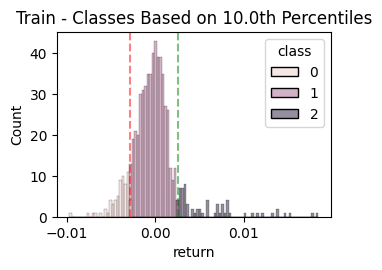

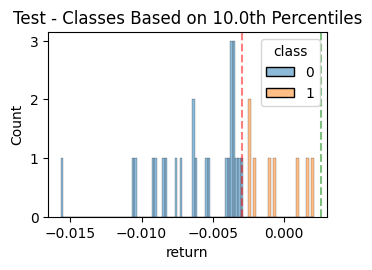

[I 2024-11-08 10:54:56,790] A new study created in memory with name: no-name-dda49b39-2f26-432d-b7ad-fb967bfb91db



Training class distribution:
Down (0): 66
Neutral (1): 522
Up (2): 66


[I 2024-11-08 10:54:57,310] Trial 0 finished with value: 0.07594445265334596 and parameters: {'max_depth': 6, 'learning_rate': 0.09412612707111816, 'n_estimators': 265, 'min_child_weight': 1, 'subsample': 0.8074368540045237, 'colsample_bytree': 0.6652326658064398, 'gamma': 0.49792061500309126}. Best is trial 0 with value: 0.07594445265334596.


Error fetching main session


/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/IPython/core/display.py:474: UserWarning:

Consider using IPython.display.IFrame instead




Overall results class distribution:
Actual:
actual
0    25
1     8
Name: count, dtype: int64

Predicted:
predicted
0    15
1    18
Name: count, dtype: int64


/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: Undef


Daily Performance Metrics:

Date: 2024-08-01
Accuracy: 0.6970
Total Samples: 33

Per-class metrics:

Down:
  Precision: 1.0000
  Recall: 0.6000
  F1 Score: 0.7500

Neutral:
  Precision: 0.4444
  Recall: 1.0000
  F1 Score: 0.6154

Up:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000

Overall Performance Metrics:
Accuracy: 0.6970
Total Samples: 33

Per-class metrics:

Down:
  Precision: 1.0000
  Recall: 0.6000
  F1 Score: 0.7500

Neutral:
  Precision: 0.4444
  Recall: 1.0000
  F1 Score: 0.6154

Up:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000

Regression Metrics (on raw targets):
RMSE: 0.7408
MAE: 0.5503


(<Figure size 2000x2000 with 9 Axes>, <Figure size 500x400 with 2 Axes>)

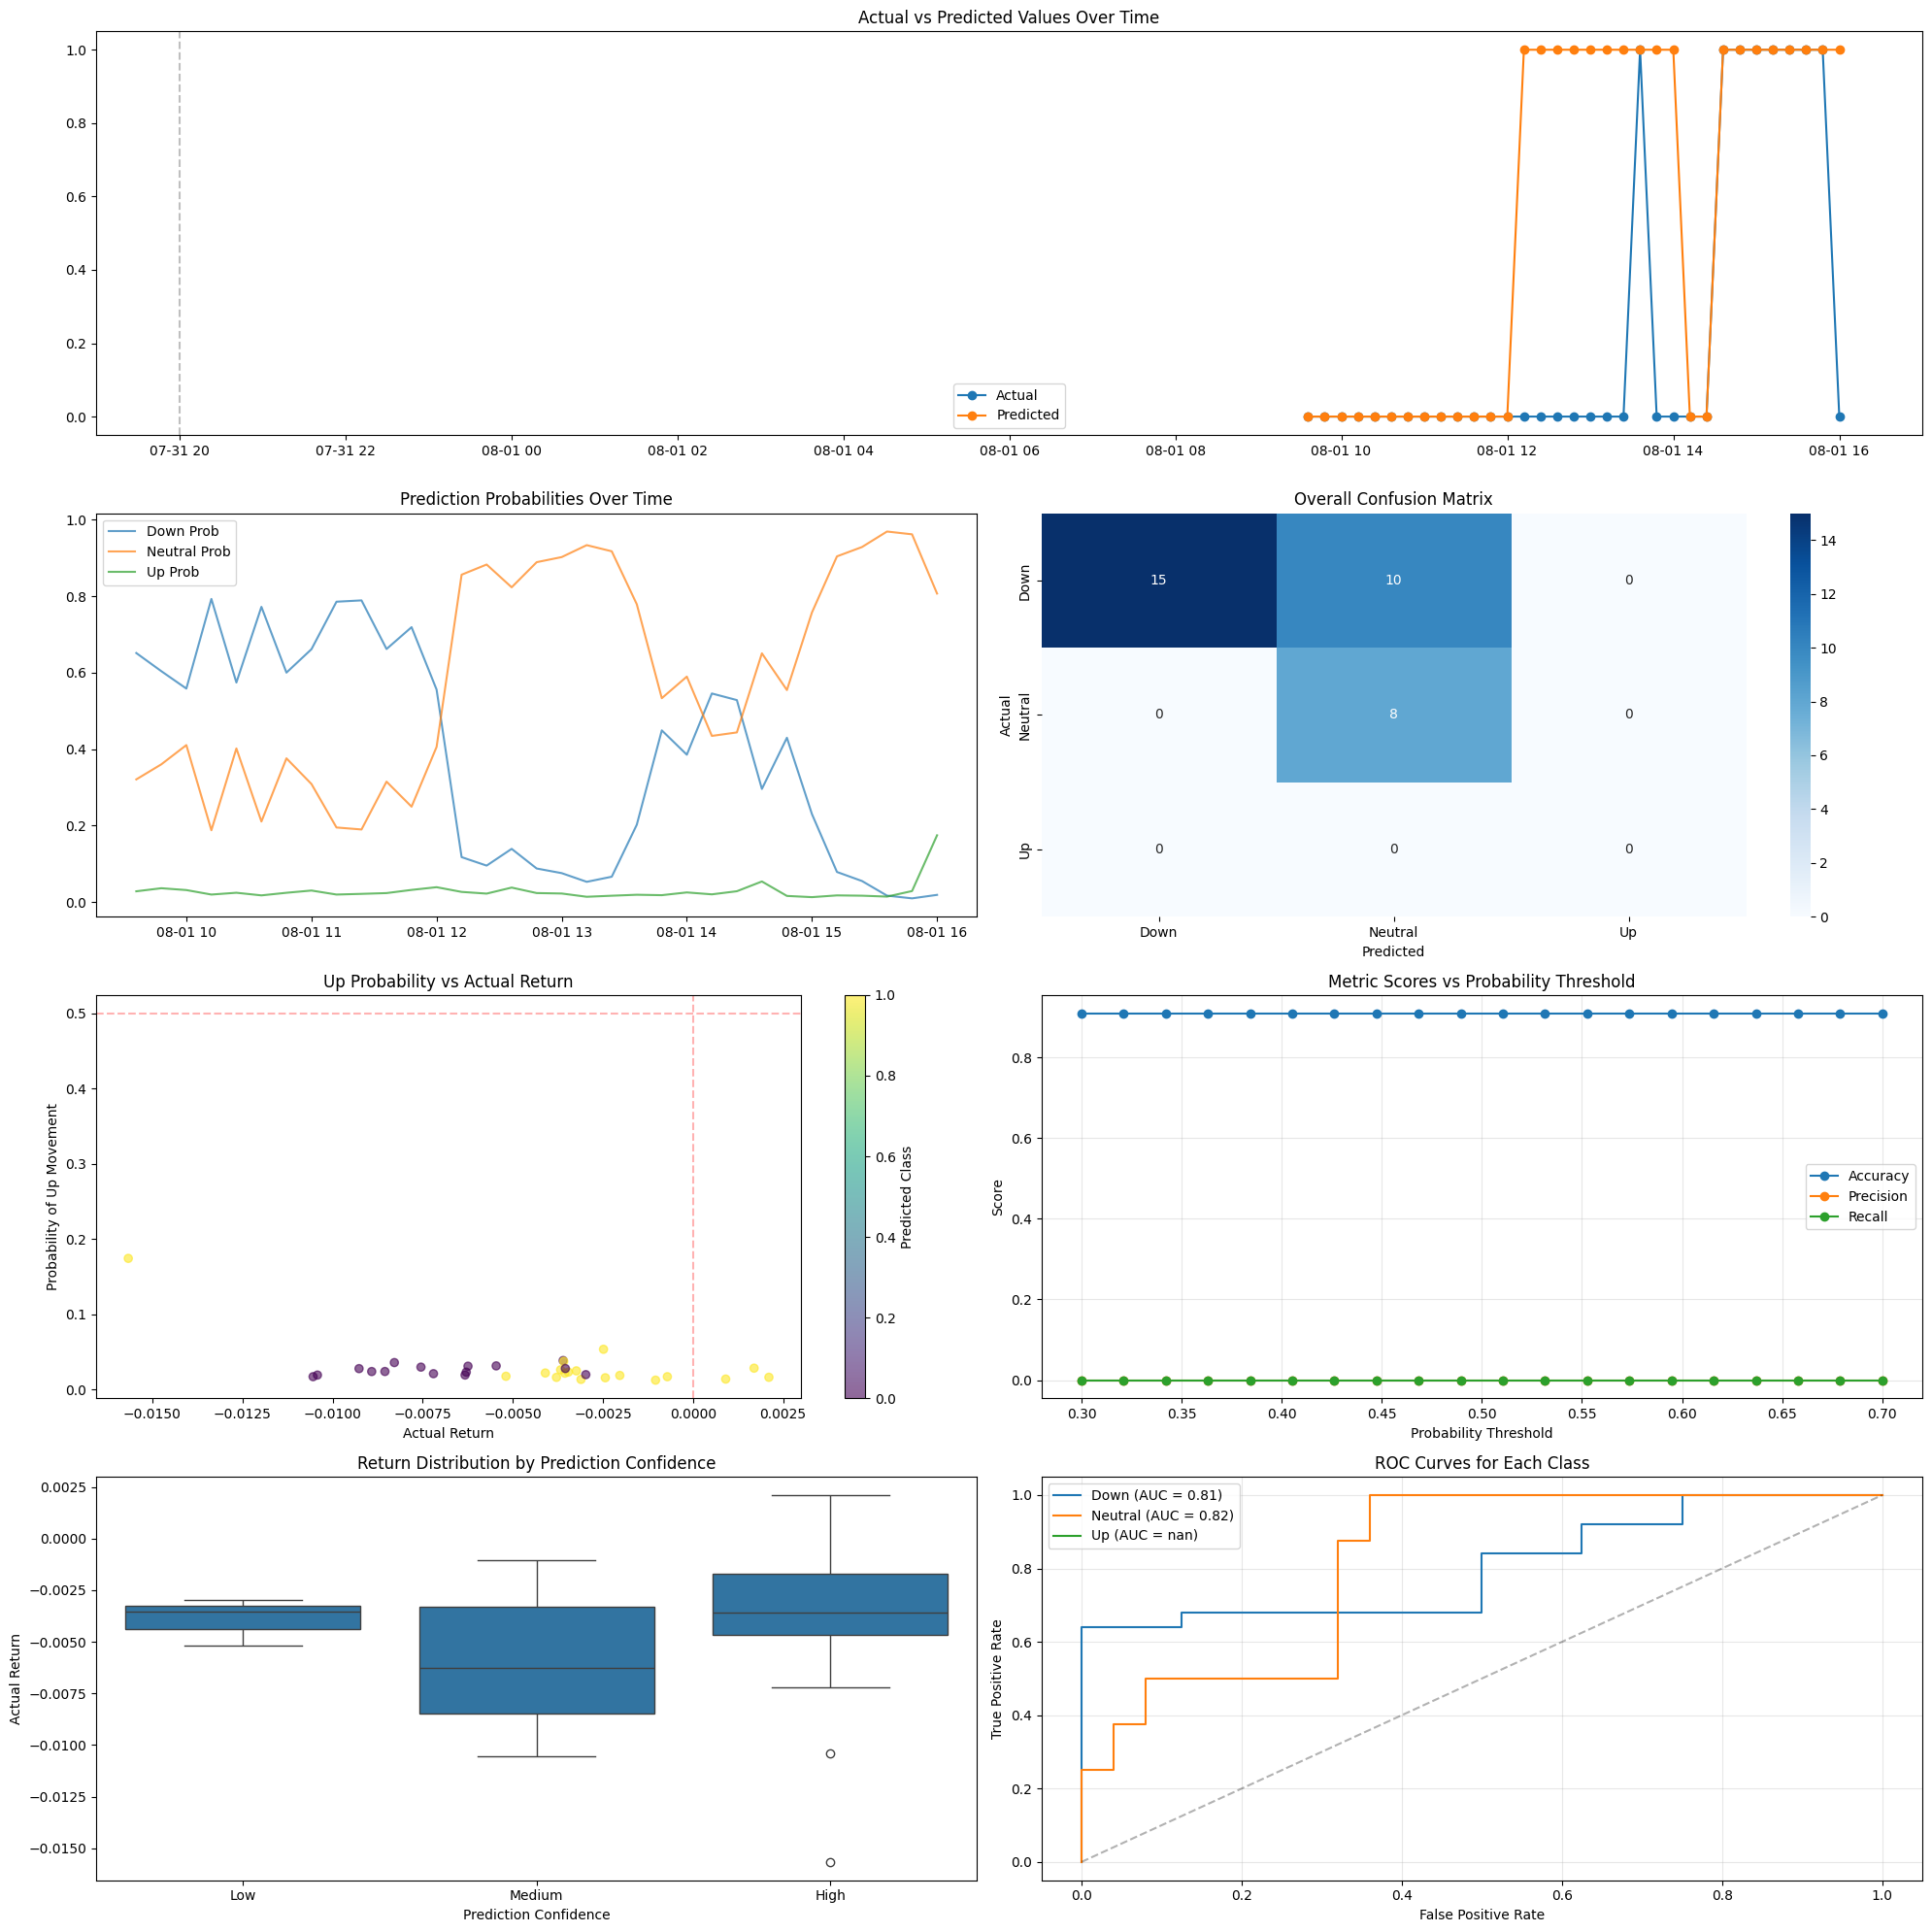

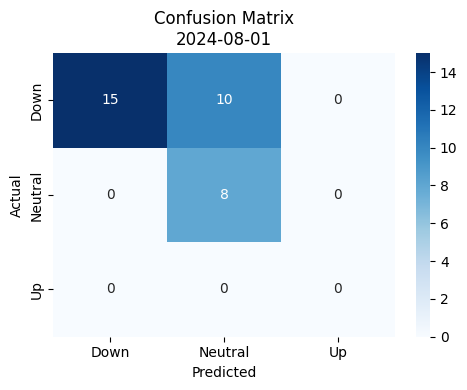

In [15]:
CSV_FILE = "features_ma_bac_720s.csv"
# Load data
df = pd.read_csv(CSV_FILE, parse_dates=['Open time'])
df.set_index('Open time', inplace=True)

#df = df[df.index > "2024-01-09 14:00:00"]
# Initialize trainer
trainer = RollingWindowTrainer(train_days=20, test_days=1)

# Run analysis for 3 iterations
results = trainer.run_rolling_window(df, n_iterations=1, n_trials=1)

# Plot results
trainer.evaluate_and_plot()
